In [117]:
import pandas as pd
import os
import glob
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Извлечение данных из файлов .xls и .xlsx
Источник: https://www.belstat.gov.by/ofitsialnaya-statistika/realny-sector-ekonomiki/tseny/potrebitelskie-tseny/operativnye-dannye/srednie-tseny-na-potrebitelskie-tovary-i-uslugi-po-respublike-belarus/

Данные там представленны в виде .xls и .xlsx по месяцам, из которых нас интересуют лишь цены на картофель в регионах РБ.

In [8]:
def extract_potato_prices(directory_path):
    all_data = []
    
    for year in range(2017, 2026):
        year_dir = os.path.join(directory_path, str(year))
        if not os.path.exists(year_dir):
            continue
        excel_files = glob.glob(os.path.join(year_dir, "Average_prices-*-*.xls*"))
        for file_path in excel_files:
            try:
                filename = os.path.basename(file_path)
                name_parts = filename.replace('.xlsx', '').replace('.xls', '').split('-')
                if len(name_parts) >= 3:
                    month = name_parts[-2]
                    year_from_file = name_parts[-1]
                    date_file = date(int(year_from_file), int(month), 1)
                    try:
                        df = pd.read_excel(file_path, header=None)
                    except Exception as e:
                        print(f"Ошибка чтения файла {file_path}: {e}")
                        continue
                    potato_row = None
                    for idx, row in df.iterrows():
                        if pd.notna(row[0]) and str(row[0]).strip().lower() == 'картофель':
                            potato_row = idx
                            break
                    if potato_row is None:
                        print(f"Строка с картофелем не найдена в файле {file_path}")
                        continue
                    if len(df) > 6:
                        regions_row = df.iloc[6]
                        potato_data = df.iloc[potato_row]
                        for col_idx in range(len(regions_row)):
                            region = regions_row.iloc[col_idx]
                            if pd.notna(region) and str(region).strip() != '':
                                price = potato_data.iloc[col_idx]
                                if pd.notna(price):
                                    try:
                                        price_value = float(price)
                                        all_data.append({
                                            'region': str(region).strip(),
                                            'date': date_file,
                                            'price': price_value
                                        })
                                    except (ValueError, TypeError):
                                        continue
                    
            except Exception as e:
                print(f"Ошибка обработки файла {file_path}: {e}")
                continue
    result_df = pd.DataFrame(all_data)
    
    return result_df

In [22]:
#df = extract_potato_prices(r'task_2_data')
df = pd.read_csv('potato_prices.csv')
df['date'] = pd.to_datetime(df['date'])

In [18]:
#df.to_csv('potato_prices.csv', index=False)

In [23]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [24]:
df

,region,date,price,year,month
0,Беларусь,2017-01-01,0.406717,2017,1
1,Брестская,2017-01-01,0.365975,2017,1
2,Витебская,2017-01-01,0.398560,2017,1
3,Гомельская,2017-01-01,0.398695,2017,1
4,Гродненская,2017-01-01,0.327980,2017,1
...,...,...,...,...,...
827,Гомельская,2025-10-01,1.100000,2025,10
828,Гродненская,2025-10-01,1.130000,2025,10
829,г. Минск,2025-10-01,1.470000,2025,10
830,Минская,2025-10-01,1.160000,2025,10


# Анализ временных рядов ценовой статистики

### Графики среднемесячной цены по Беларуси  

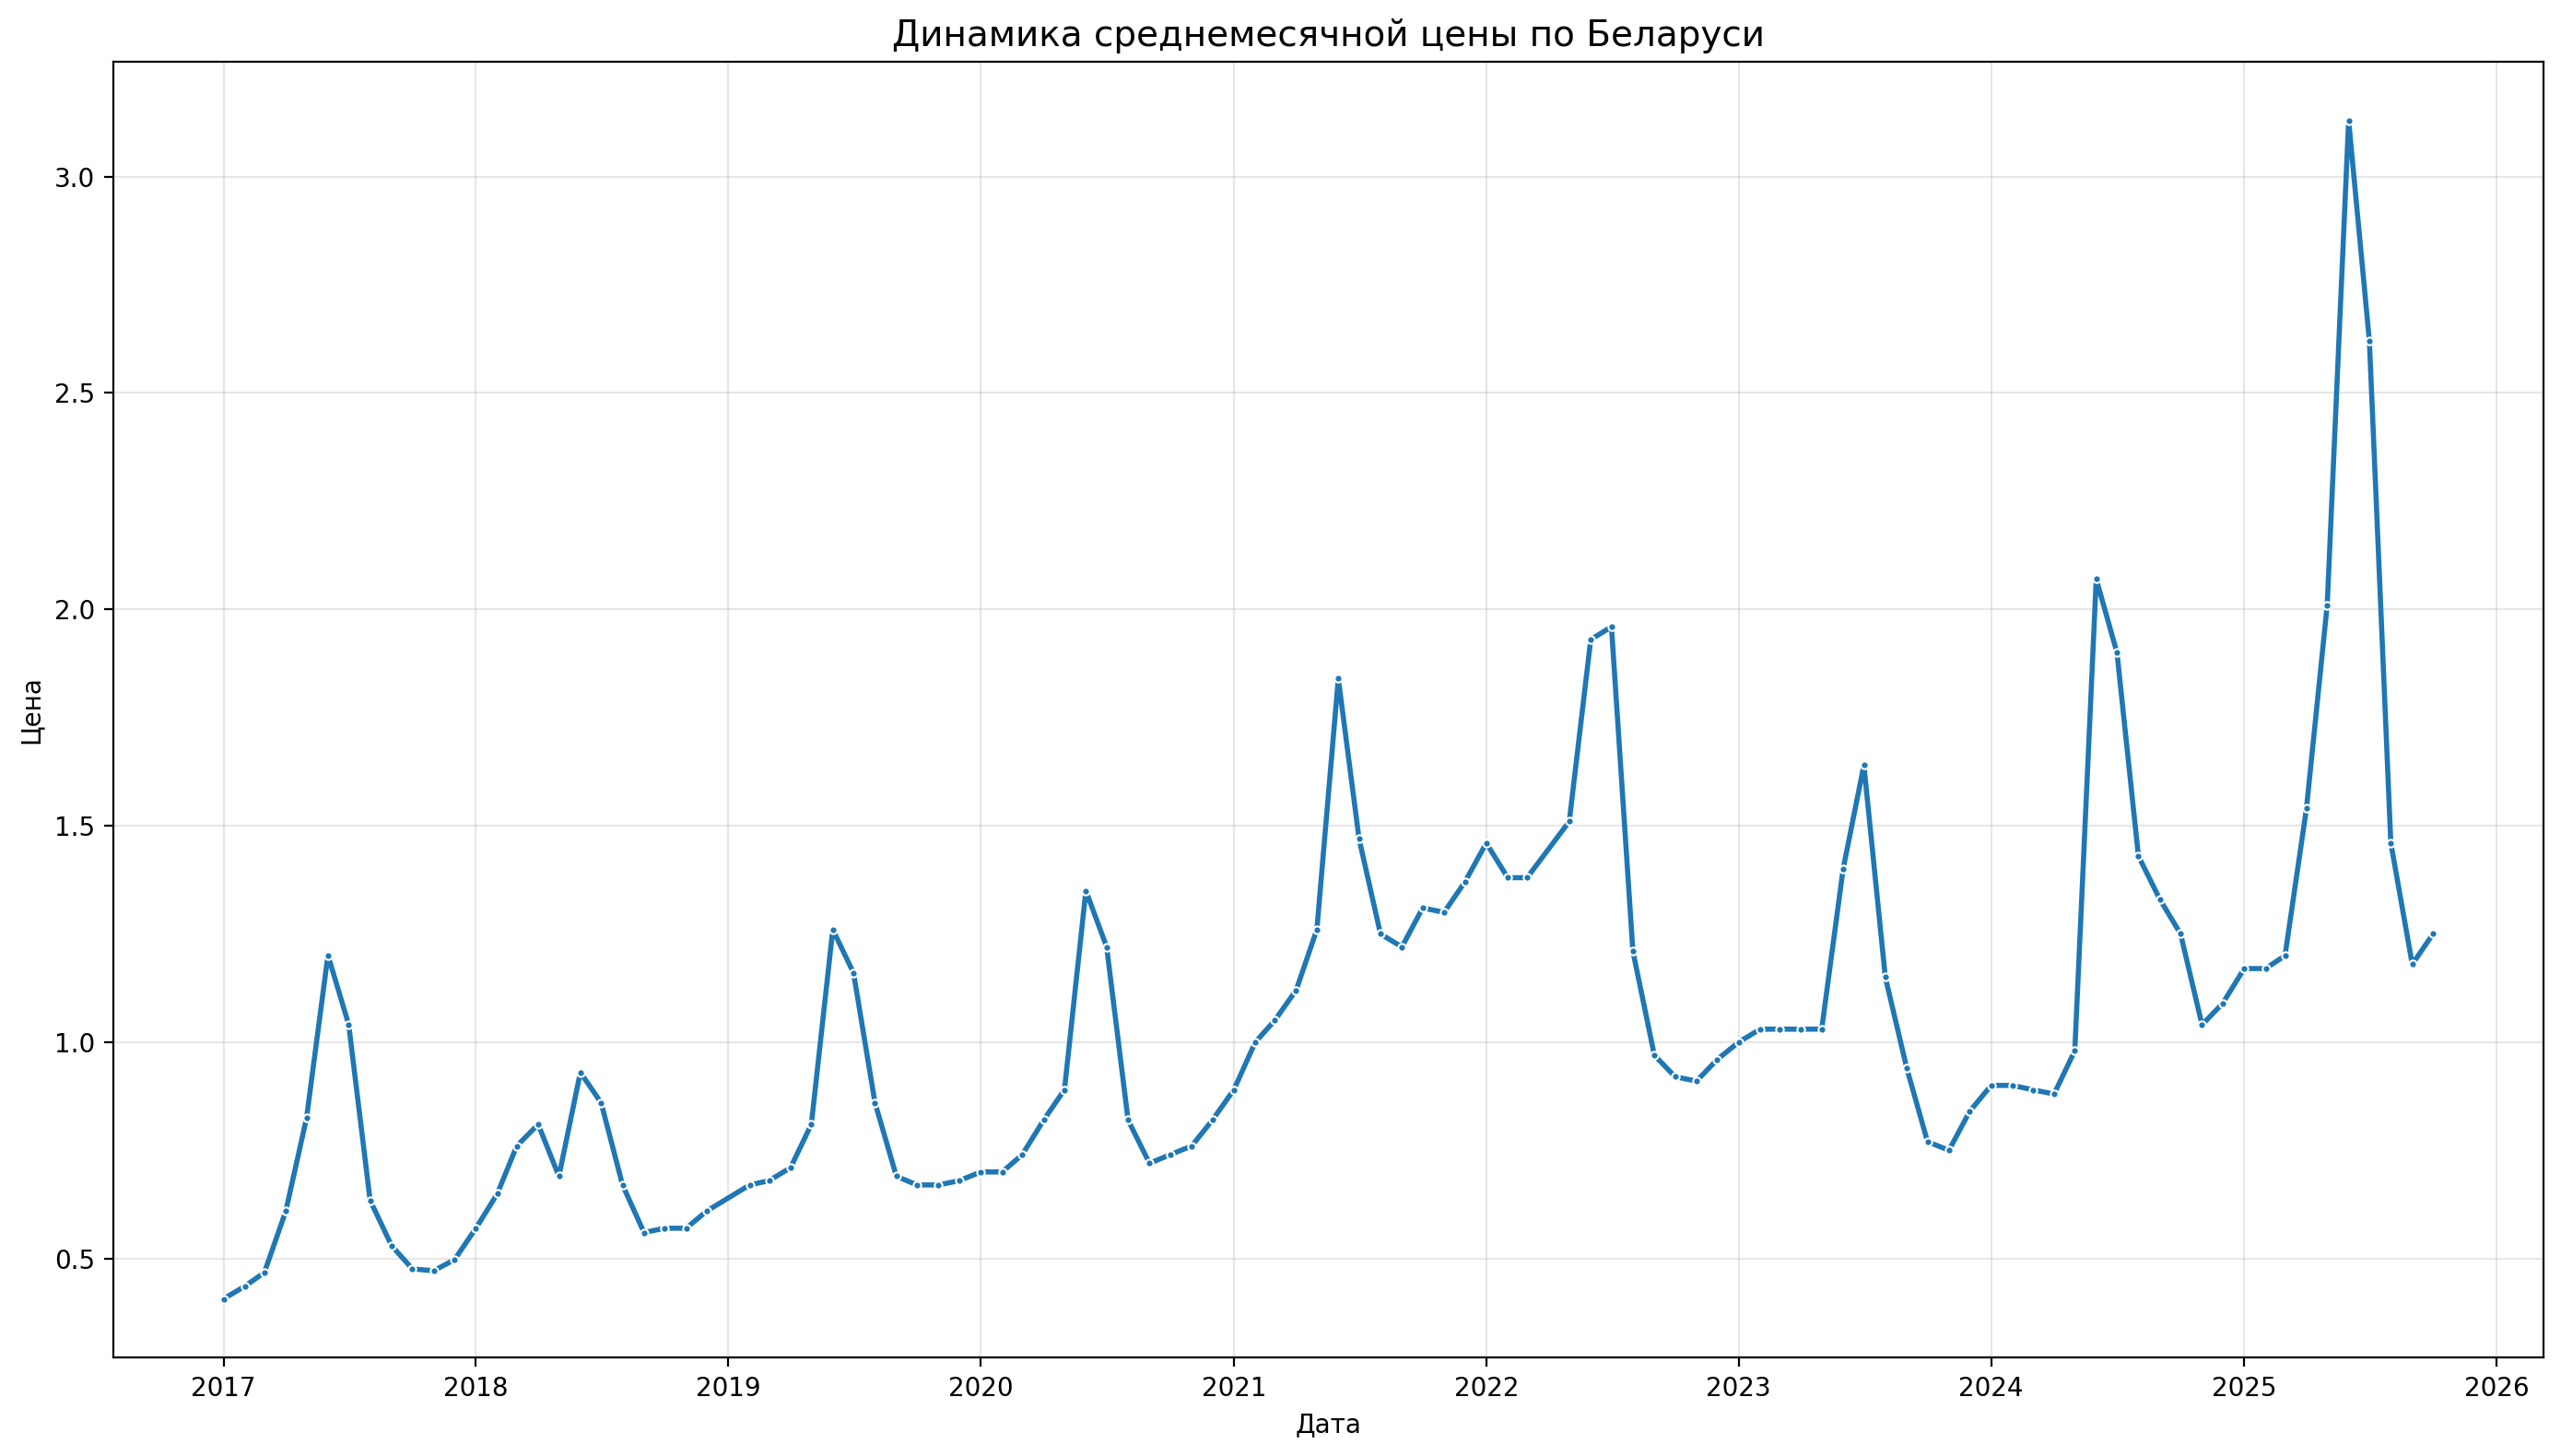

In [91]:
plt.figure(figsize=(14, 8), dpi=200)
sns.lineplot(df[df['region'] == 'Беларусь'], x='date', y='price',
             marker='o', linewidth=2, markersize=3)
plt.title('Динамика среднемесячной цены по Беларуси', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.grid(True, alpha=0.3)
plt.tight_layout();

### Базовая статистика по регионам

In [66]:
stats_by_region = df.groupby('region')['price'].describe().transpose()
stats_by_region

region,Беларусь,Брестская,Витебская,Гомельская,Гродненская,Минская,Могилевская,г. Минск
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,1.044753,1.031204,1.002147,0.987394,0.943926,1.020236,0.927988,1.189094
std,0.452828,0.515528,0.419859,0.481624,0.429224,0.422579,0.393894,0.512773
min,0.406717,0.365975,0.398560,0.396063,0.327980,0.387200,0.369840,0.483100
25%,0.717500,0.707500,0.688736,0.650000,0.627500,0.700000,0.627500,0.827500
50%,0.950000,0.941013,0.880000,0.885000,0.865000,0.945000,0.850000,1.105700
75%,1.250000,1.232500,1.242500,1.260000,1.130000,1.255000,1.110000,1.332500
max,3.130000,3.950000,2.450000,3.450000,2.470000,2.610000,2.550000,3.830000


In [79]:
yearly_dynamics = df.groupby(['region', 'year'])['price'].mean().unstack('region')

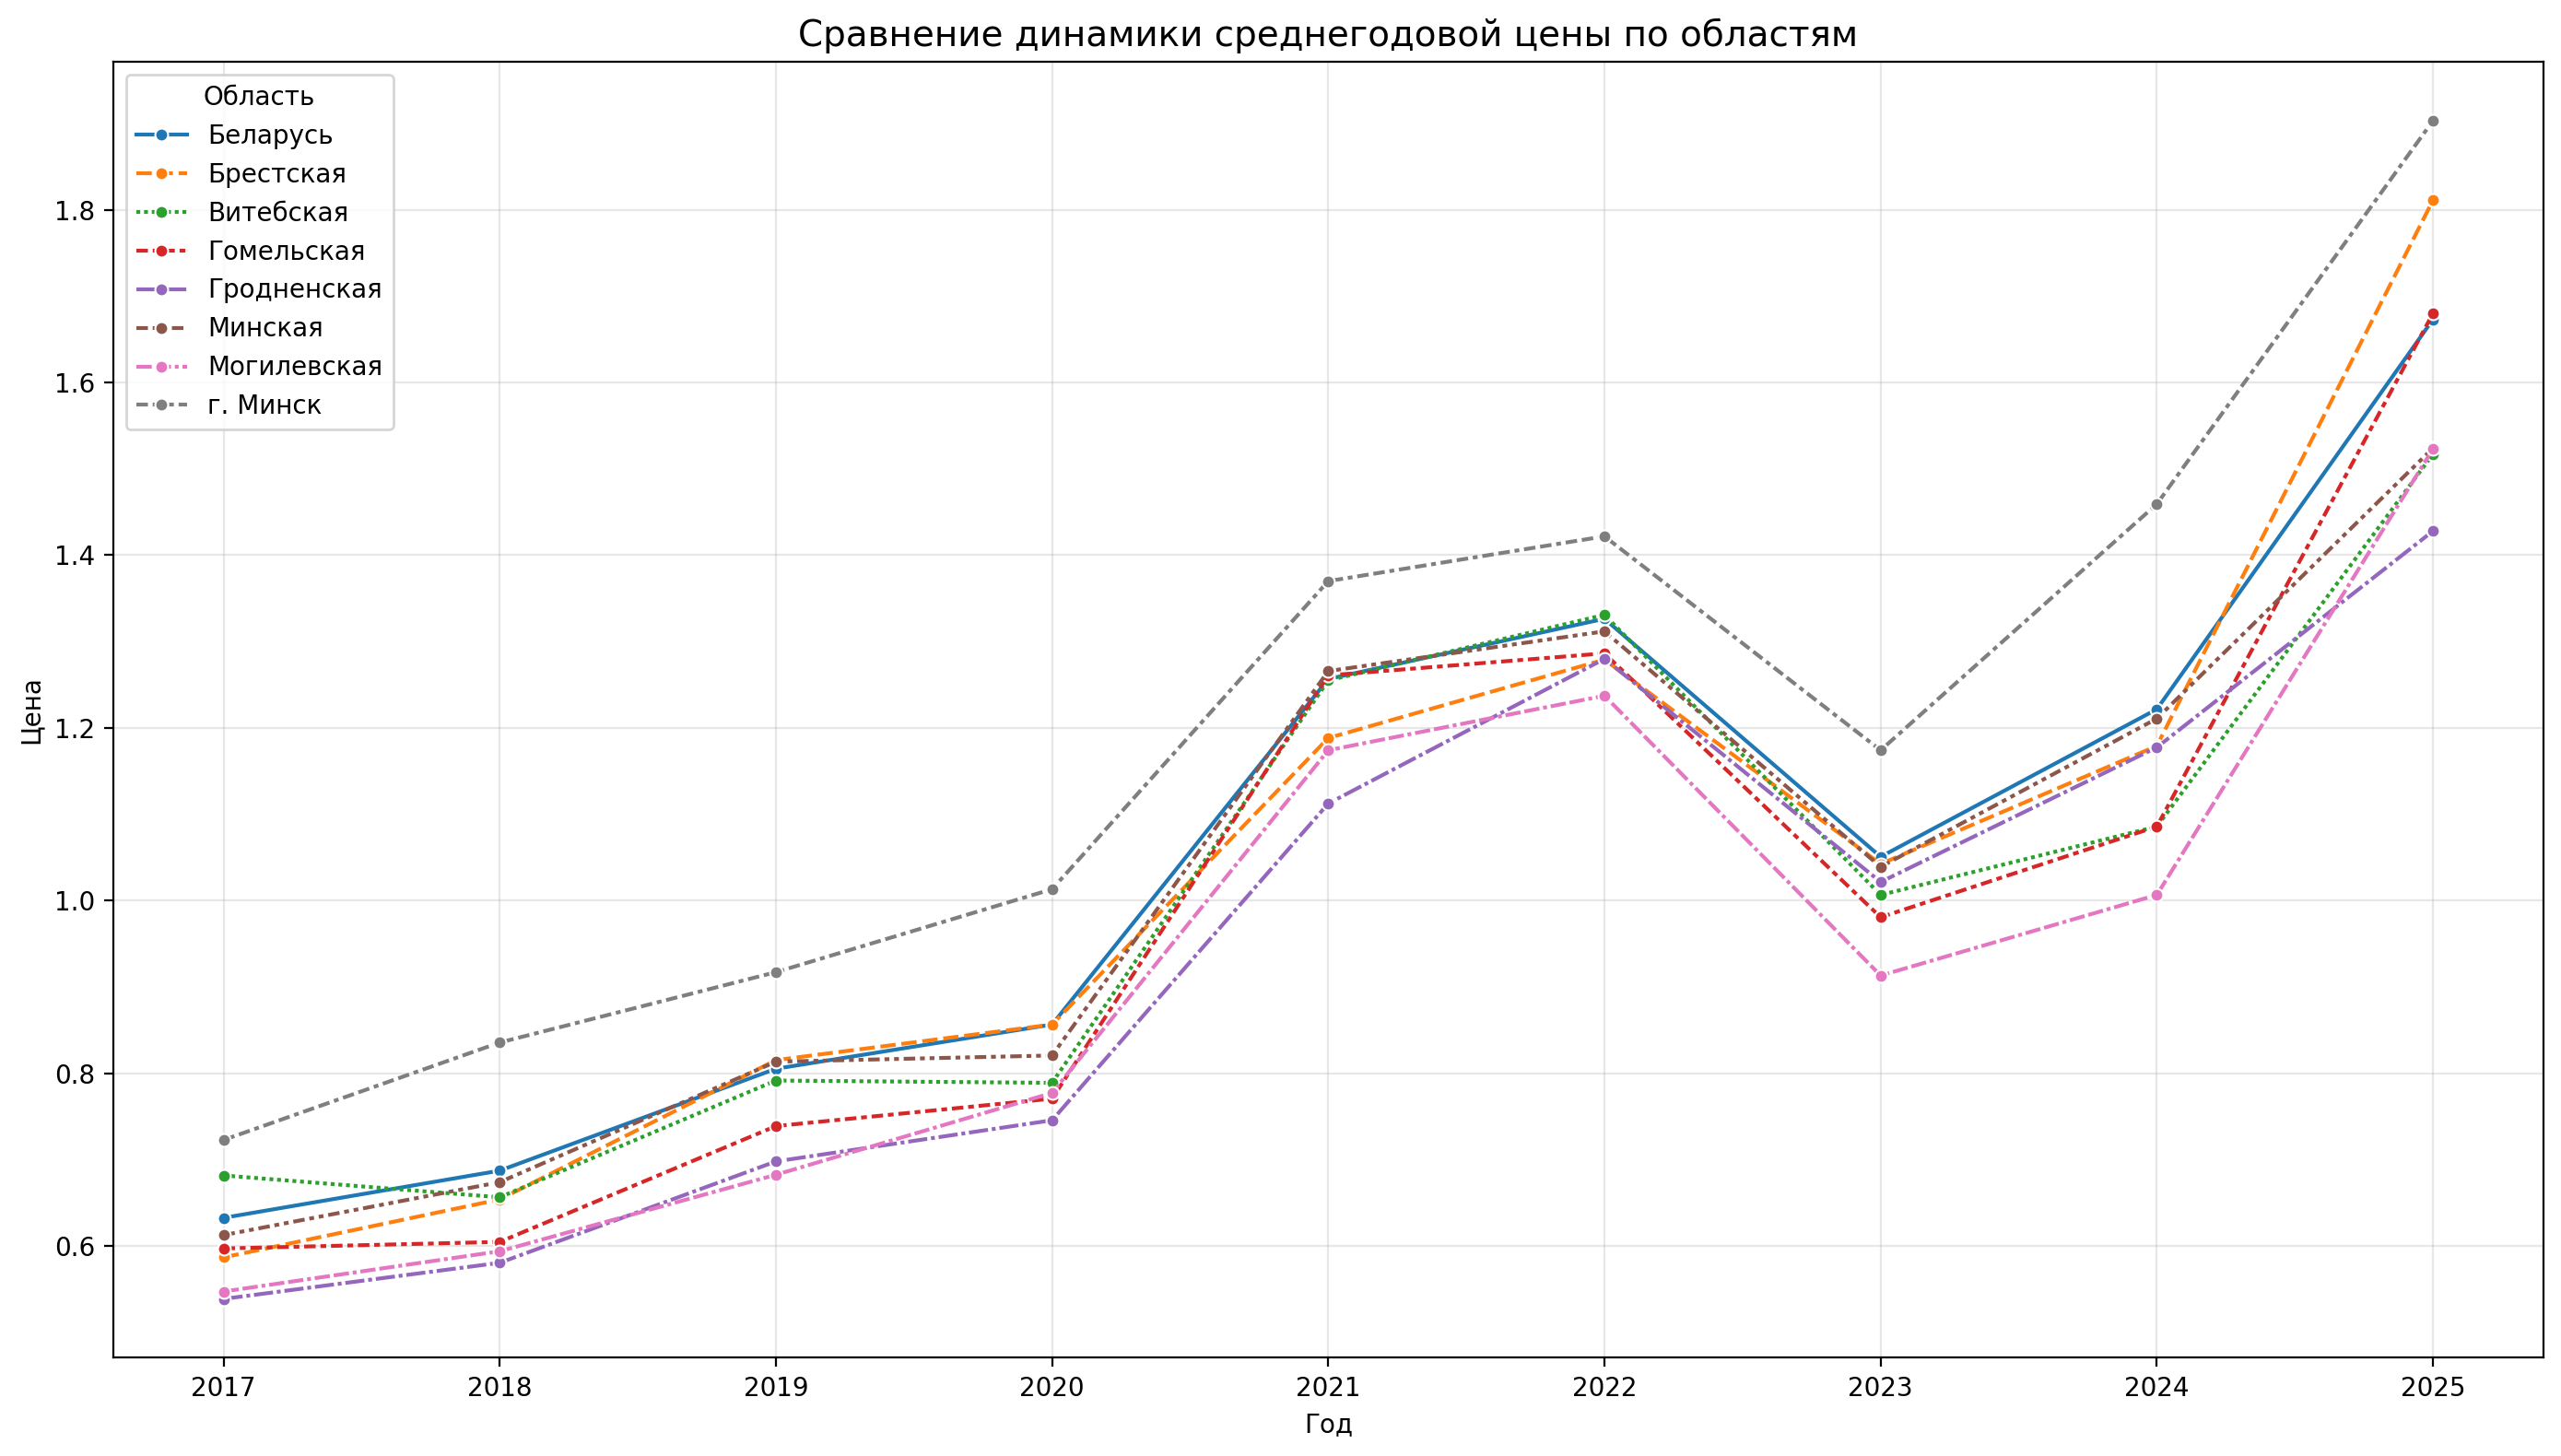

In [123]:
plt.figure(figsize=(14, 8), dpi=200)
sns.lineplot(yearly_dynamics, marker='o', 
             linewidth=1.5, markersize=5)
plt.title('Сравнение динамики среднегодовой цены по областям', fontsize=14)
plt.xlabel('Год')
plt.ylabel('Цена')
plt.legend(title='Область')
plt.grid(True, alpha=0.3)
plt.tight_layout();

In [93]:
volatility = df.groupby('region')['price'].std().sort_values(ascending=False)
volatility

region
Брестская      0.515528
г. Минск       0.512773
Гомельская     0.481624
Беларусь       0.452828
Гродненская    0.429224
Минская        0.422579
Витебская      0.419859
Могилевская    0.393894
Name: price, dtype: float64

# Выявление сезонных и циклических компонент

In [29]:
seasonal_pattern = df.groupby('month')['price'].mean()

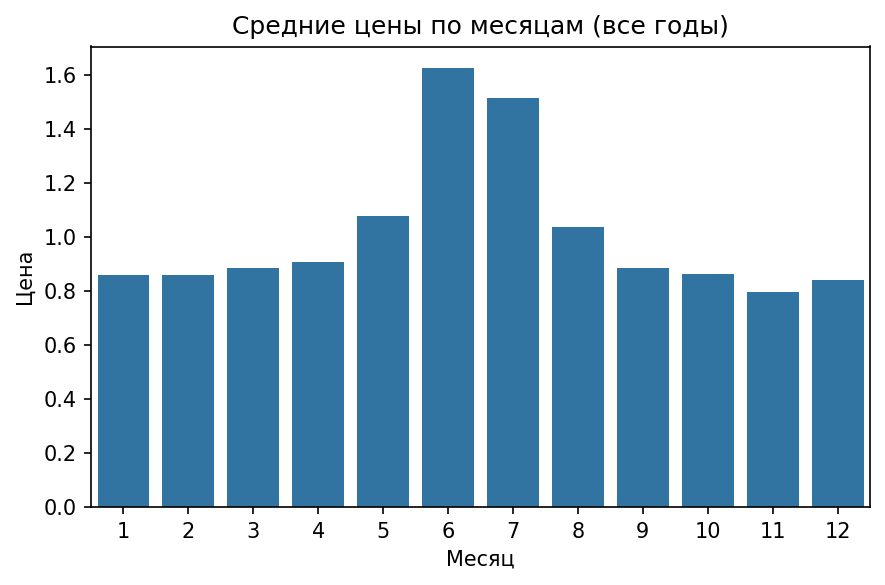

In [30]:
plt.figure(figsize=(6, 4), dpi=150)
sns.barplot(seasonal_pattern)
plt.title('Средние цены по месяцам (все годы)')
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.tight_layout();

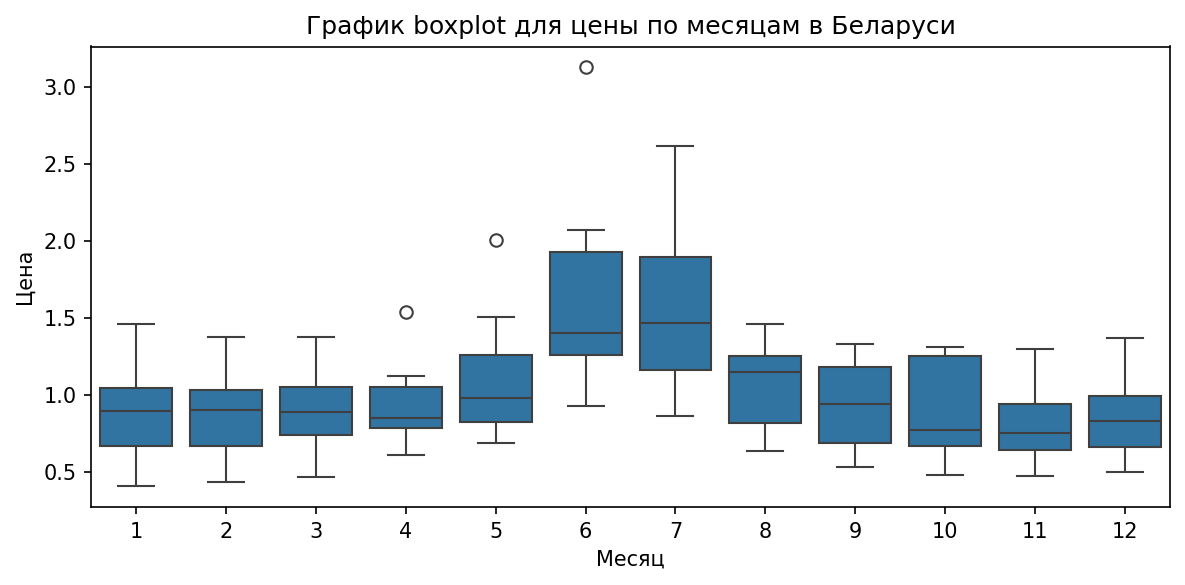

In [27]:
plt.figure(figsize=(8, 4), dpi=150)
sns.boxplot(df[df['region'] == 'Беларусь'], x='month', y='price')
plt.title('График boxplot для цены по месяцам в Беларуси')
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.tight_layout();


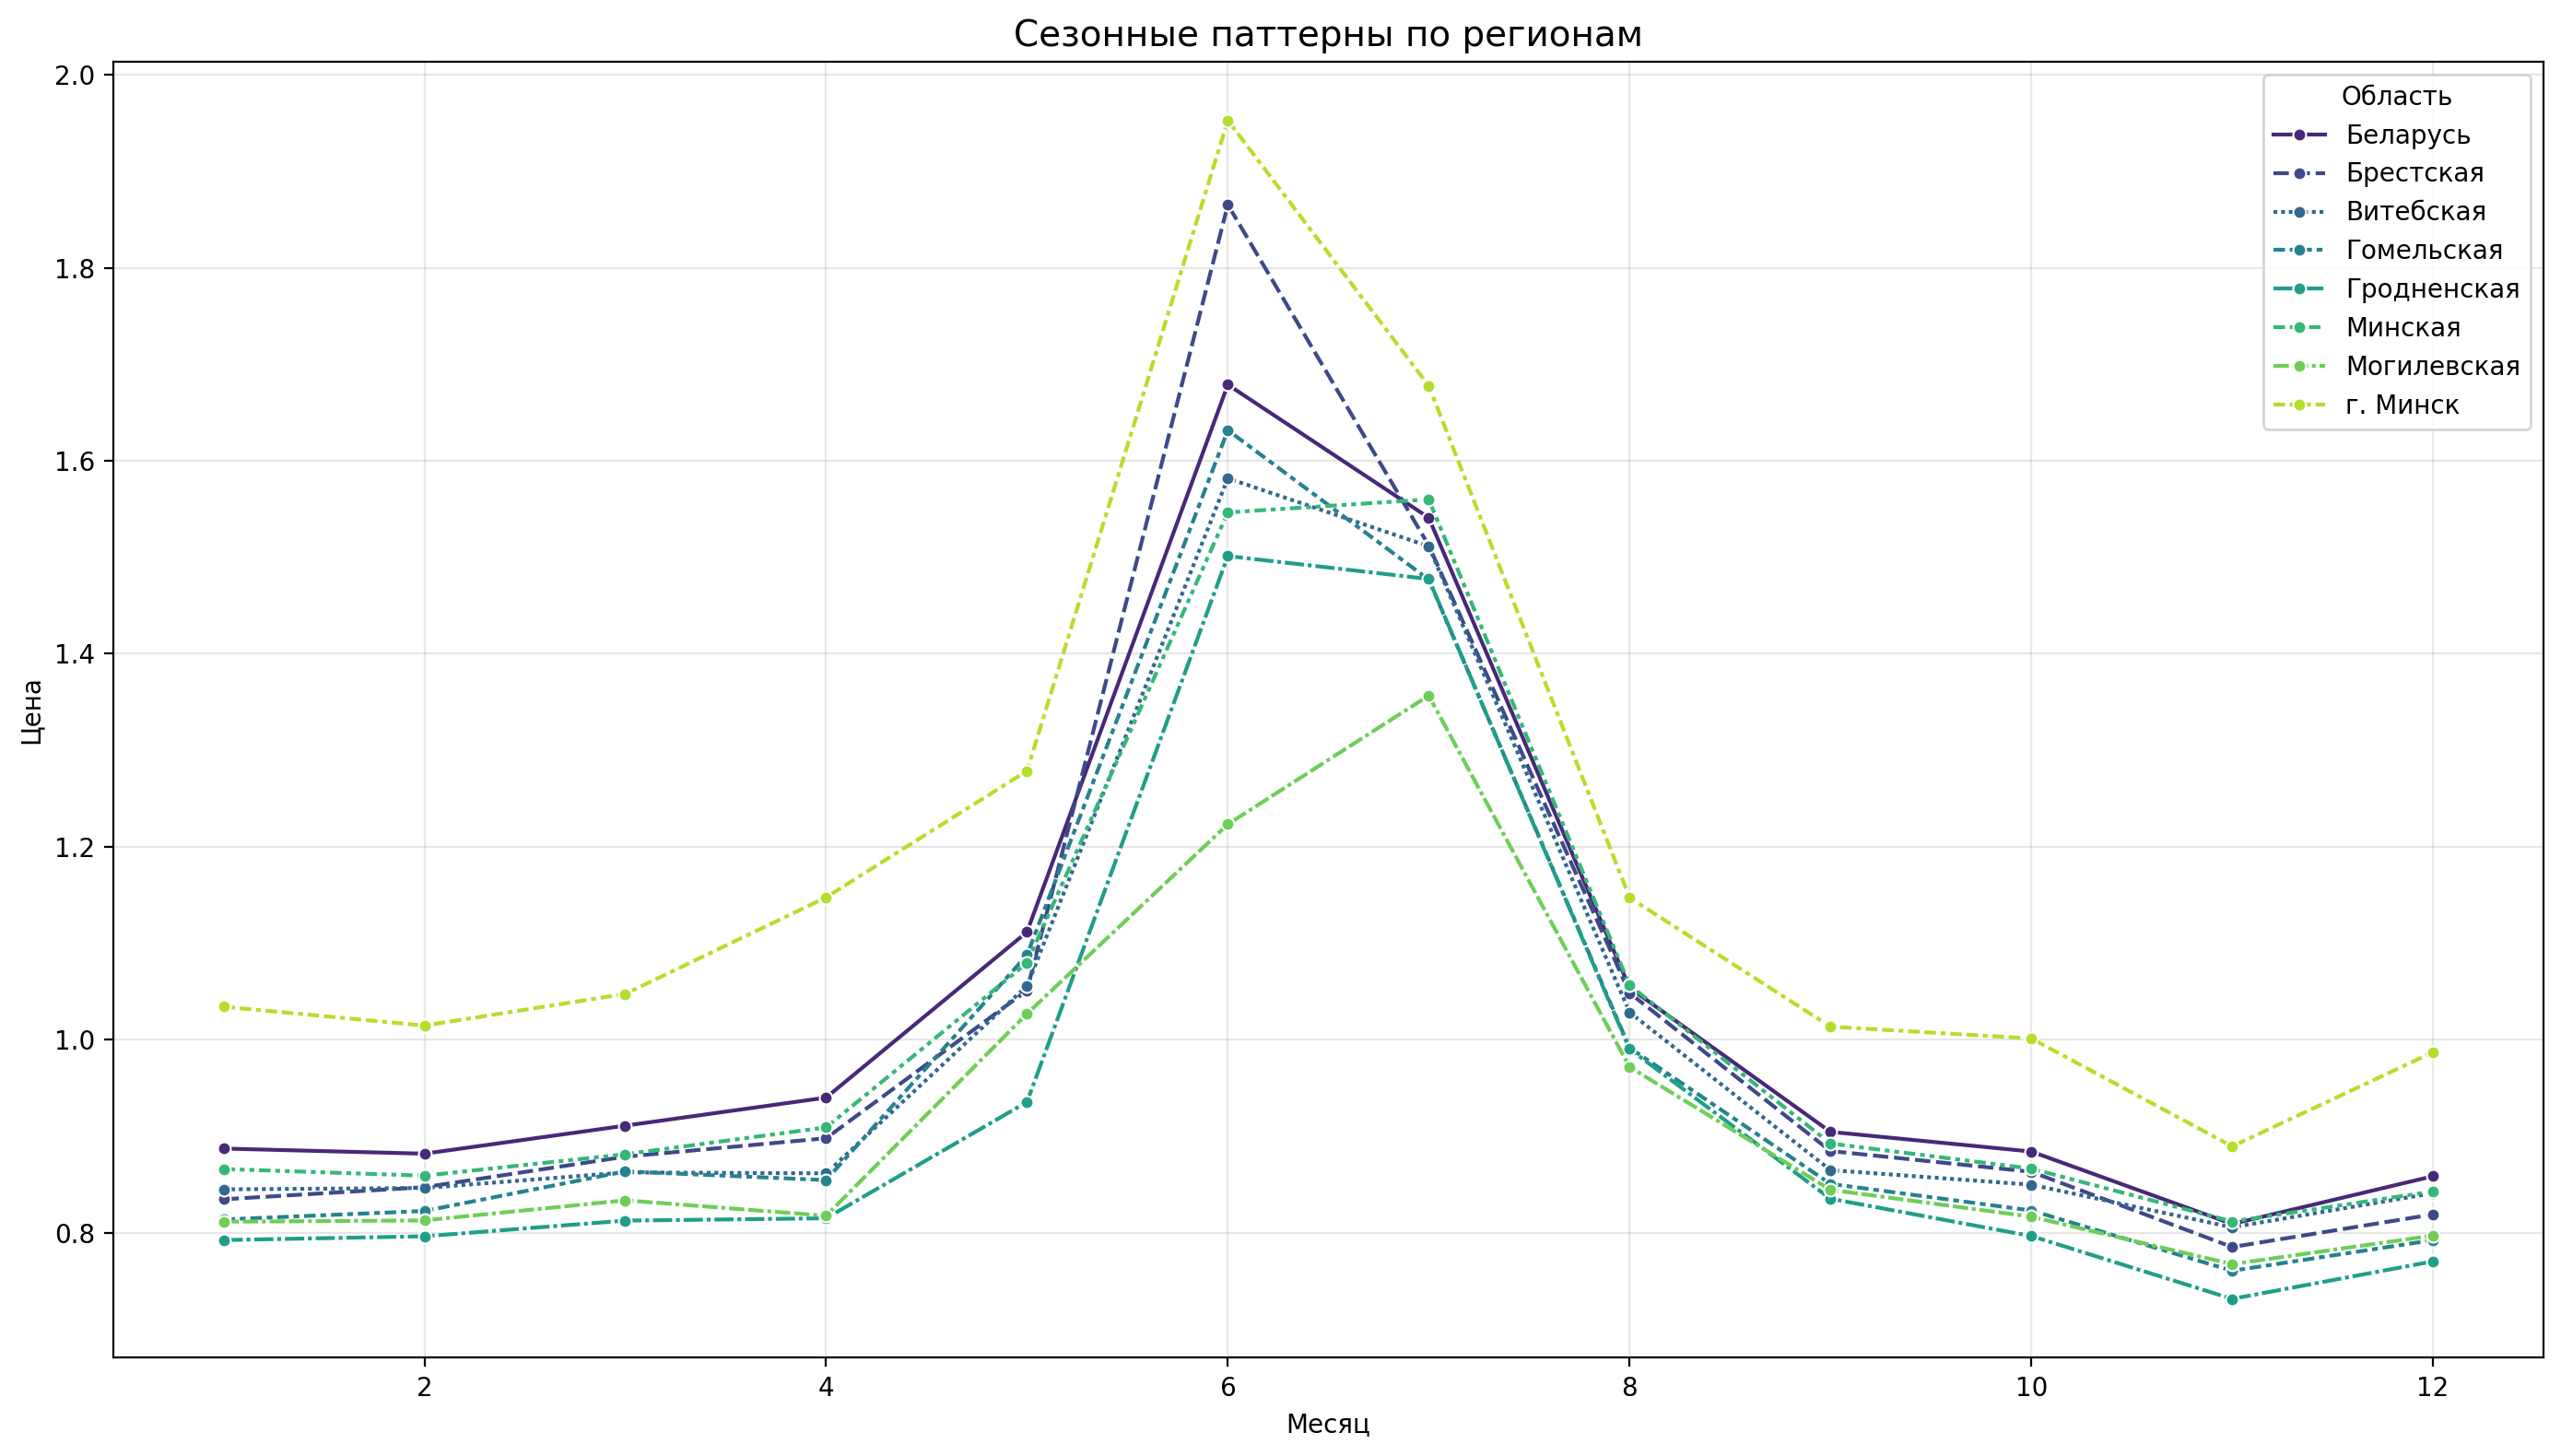

In [126]:
seasonal_by_region = df.groupby(['region', 'month'])['price'].mean().unstack('region')
plt.figure(figsize=(14, 8), dpi=200)
sns.lineplot(seasonal_by_region, marker='o', 
             linewidth=1.5, markersize=5, palette='viridis')
plt.title('Сезонные паттерны по регионам', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.legend(title='Область')
plt.grid(True, alpha=0.3)
plt.tight_layout();

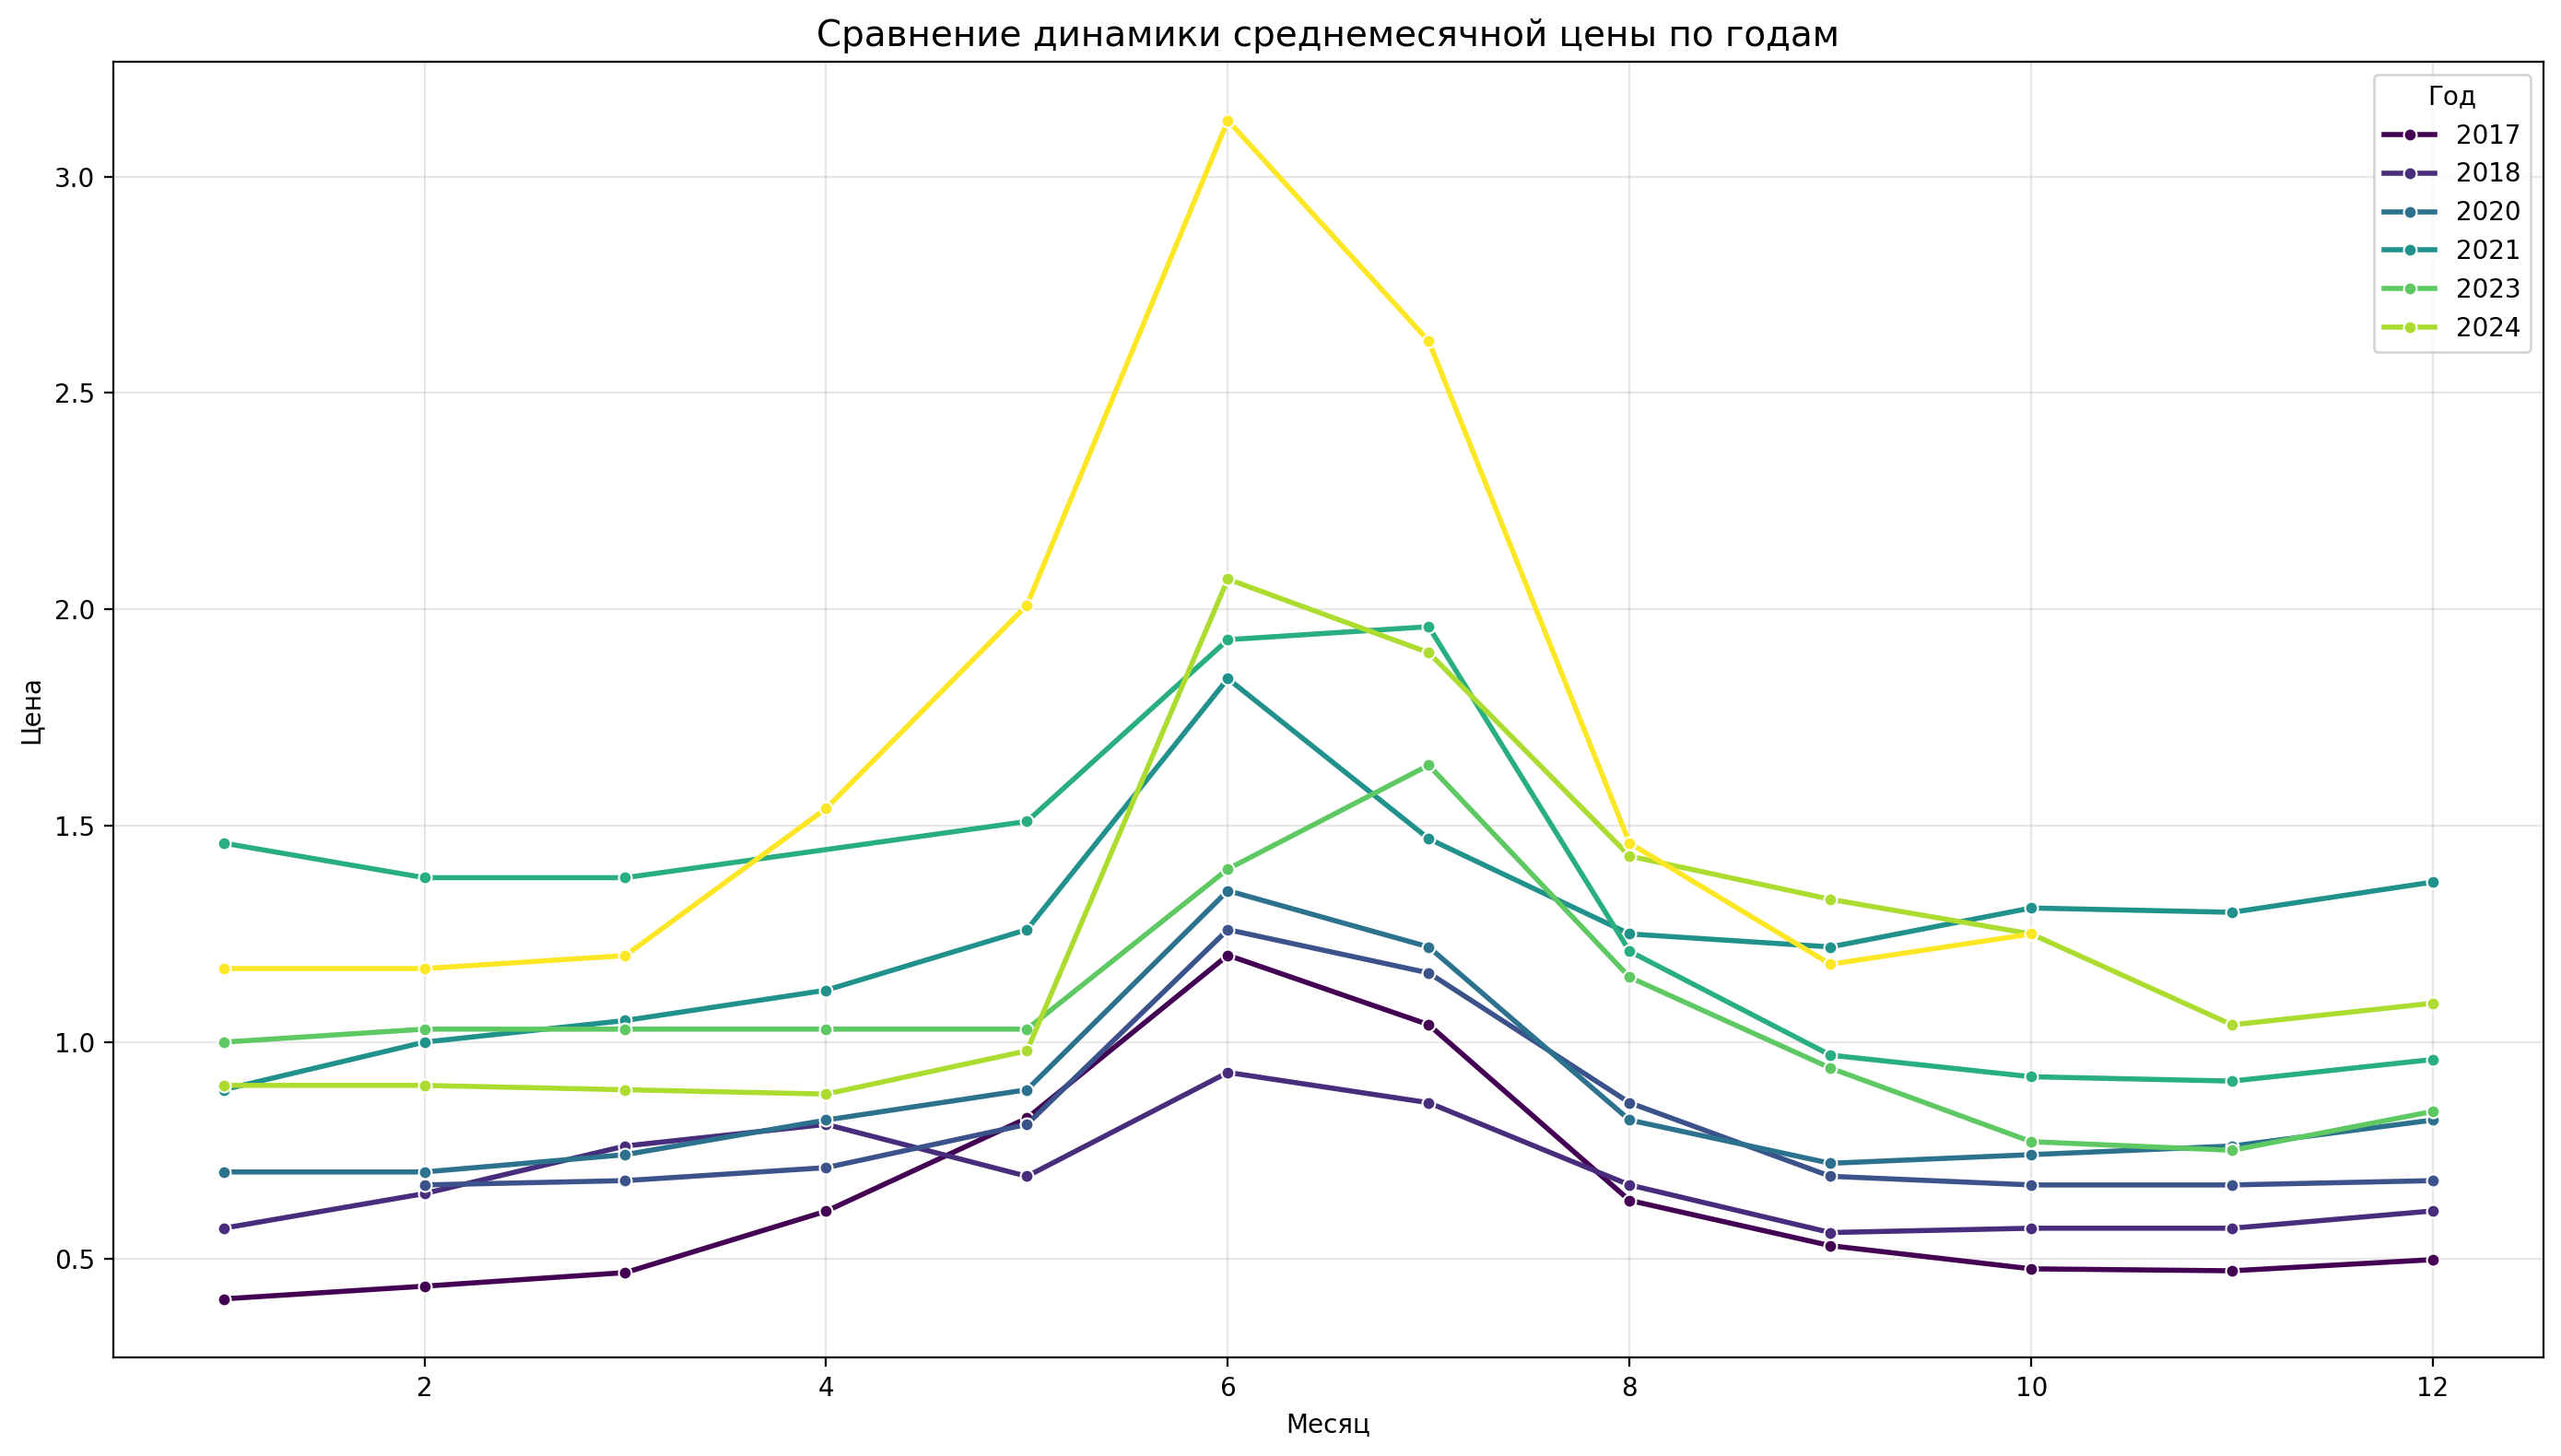

In [125]:
plt.figure(figsize=(14, 8), dpi=200)
sns.lineplot(df[df['region'] == 'Беларусь'], x='month', y='price', hue='year', 
             marker='o', linewidth=2, markersize=5, palette='viridis')
plt.title('Сравнение динамики среднемесячной цены по годам', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.legend(title='Год')
plt.grid(True, alpha=0.3)
plt.tight_layout();

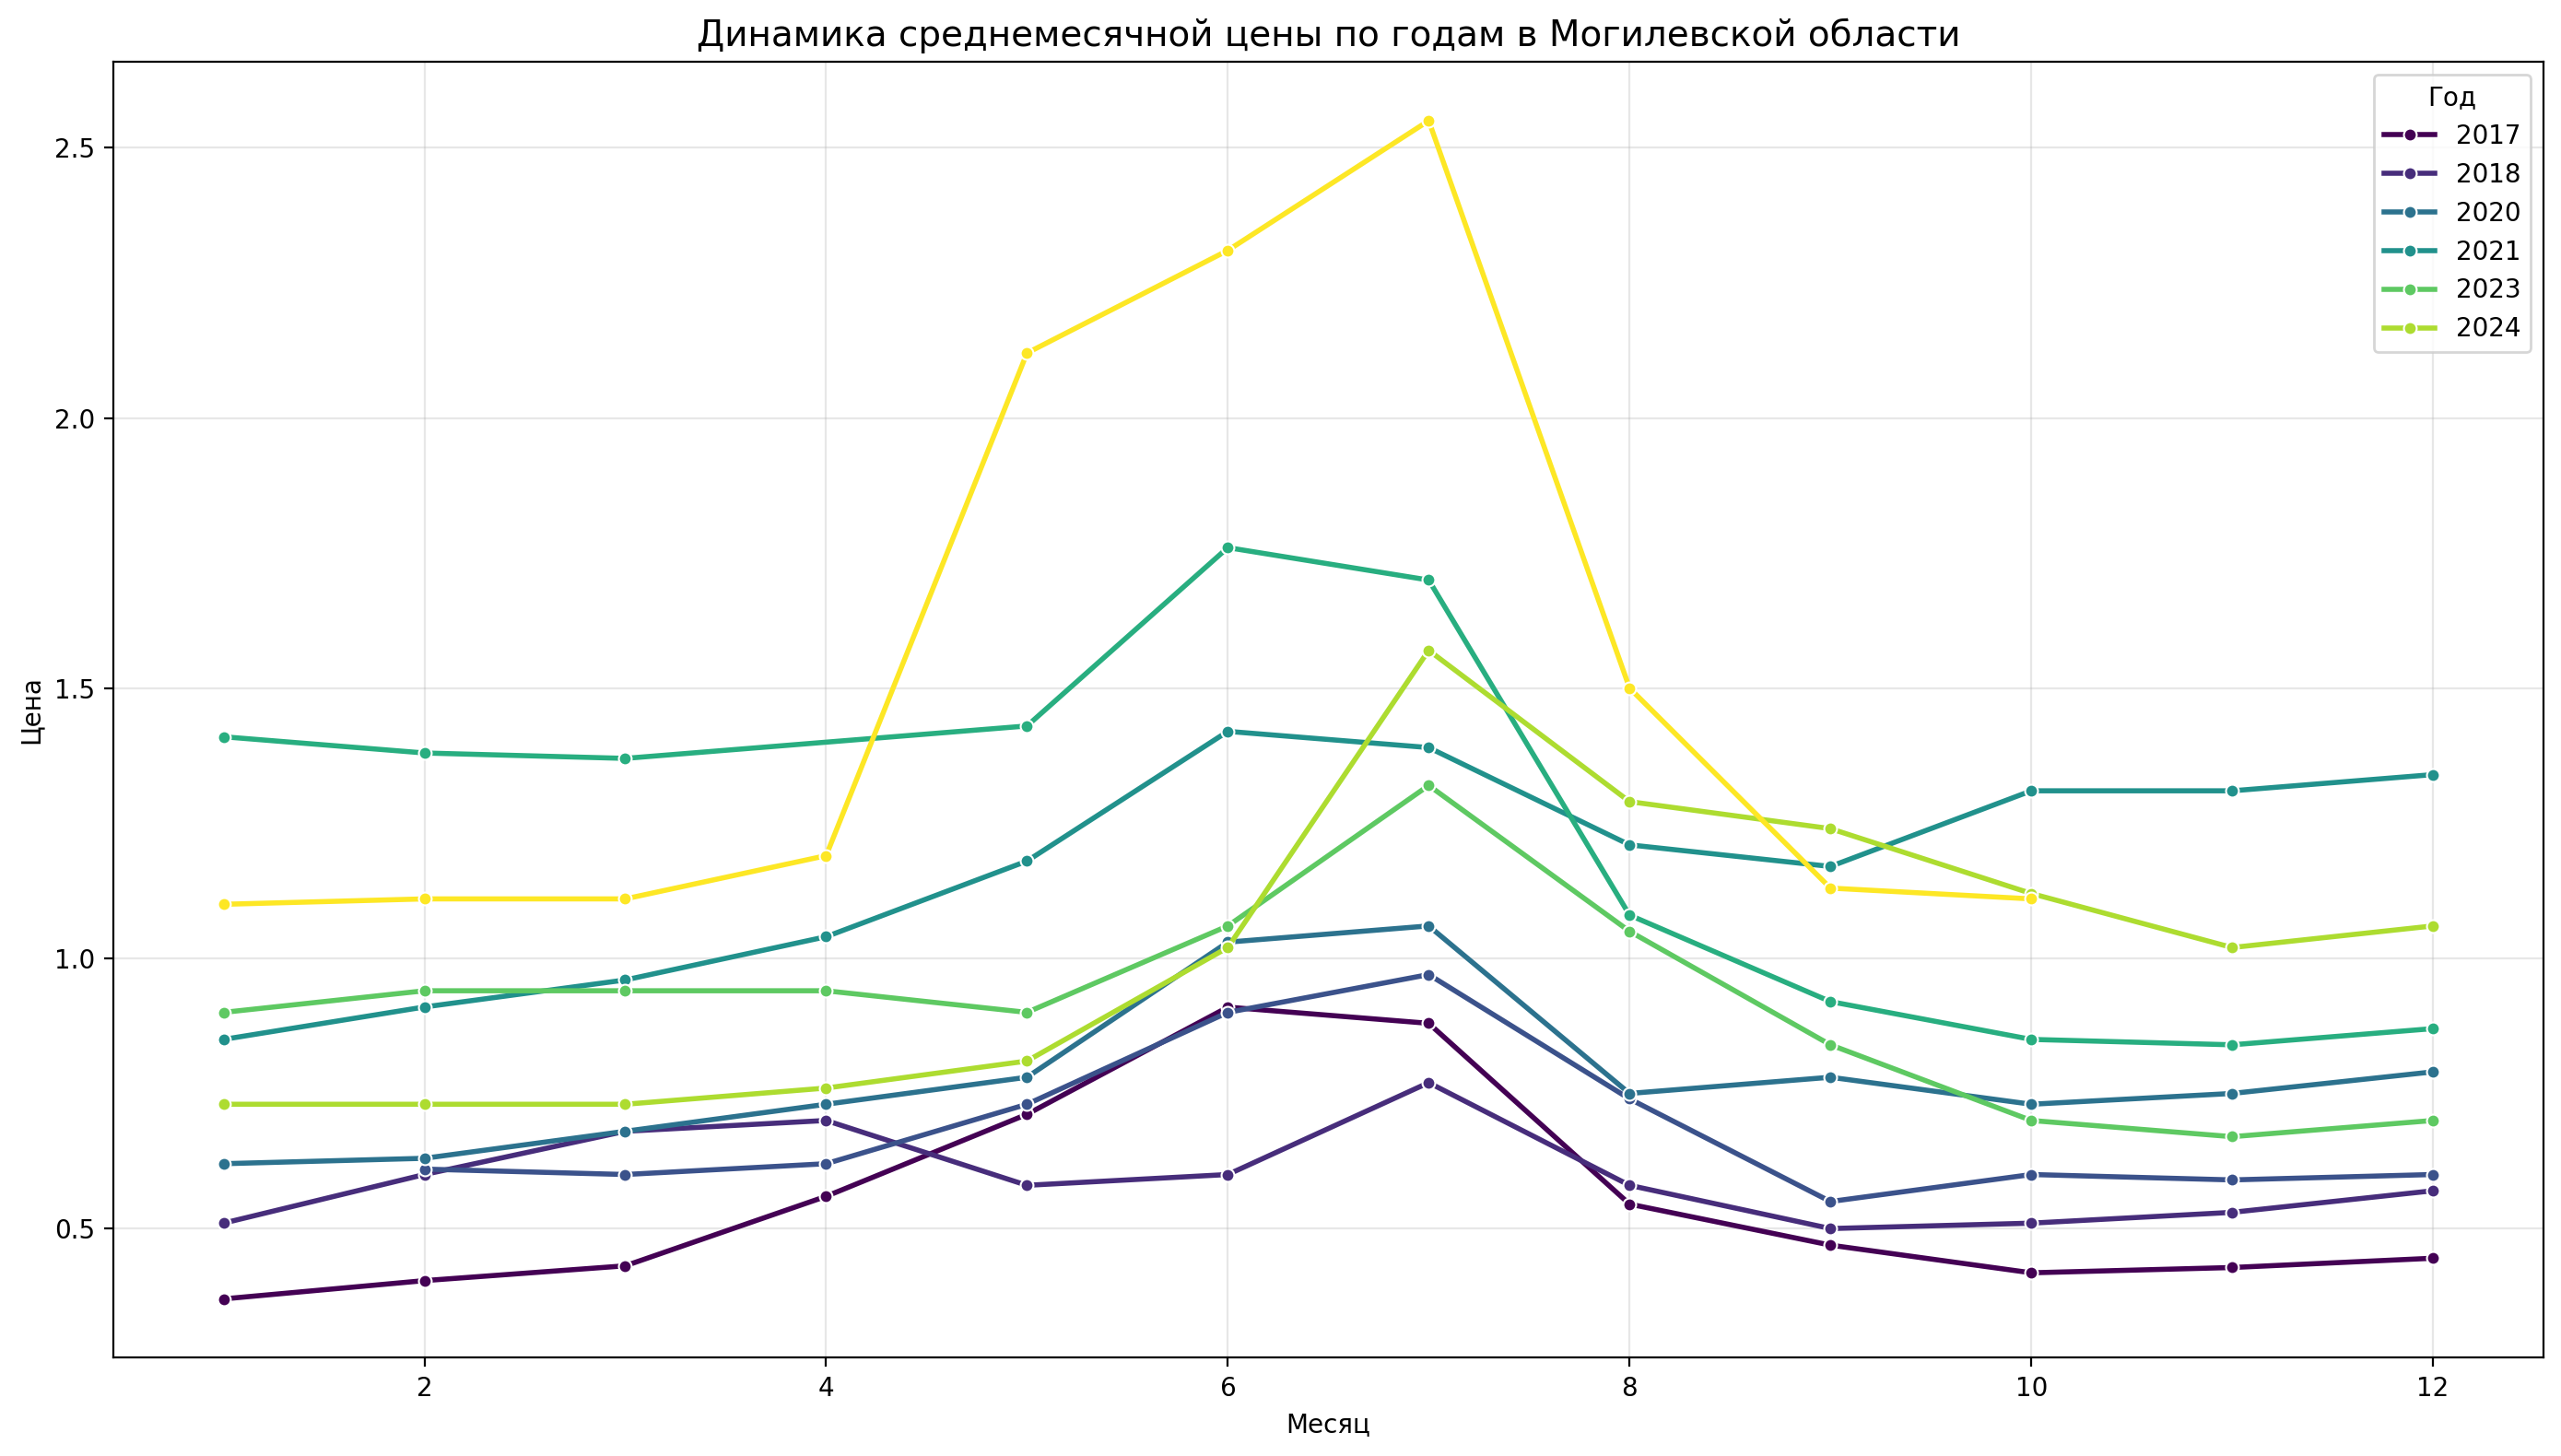

In [129]:
plt.figure(figsize=(14, 8), dpi=200)
sns.lineplot(df[df['region'] == 'Могилевская'], x='month', y='price', hue='year', 
             marker='o', linewidth=2, markersize=5, palette='viridis')
plt.title('Динамика среднемесячной цены по годам в Могилевской области', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.legend(title='Год')
plt.grid(True, alpha=0.3)
plt.tight_layout();

По графикам ясно видно, что присутствует сезонная компонента: в любой из годов примерно с мая средняя цена достаточно резко идет вверх, достигает пика в июне и затем, в более ранние года плавно, а в более поздние - резко, идет вниз, примерно к сентябрю выходя на уровень, который был до подъема. 

По регионам можно видеть лишь довольно сильное отличие Могилевской области, в сравнении с другими регионами ее график оличается сильнее всего: в июне цена ощутимо ниже, чем в других областях, и она в этом месяце продолжает расти, а пика достигает только в июле, однако дальше ведет себя примерно так же, как и в других регионах.
Возможно такая разница связана с тем, что Могилевская область является крупным производителем и поставщиком картофеля в Беларуси, уступая лишь Минской области (по данным на 2025 год), в то время как население в Могилевской почти в полтора раза ниже, чем в Минской (и это без учета самого Минска), из-за чего локально в Могилевской области в июне спрос превышает предложение, а сезонное подорожание наступает немного позже.

In [140]:
def decompose_time_series(region_data: pd.DataFrame, window=12):
    data = region_data.set_index('date').sort_index()
    data['trend'] = data['price'].rolling(window=window, center=True).mean()
    detrended = data['price'] - data['trend']
    seasonal_pattern = detrended.groupby(data.index.month).mean()
    data['seasonality'] = data.index.month.map(seasonal_pattern)
    data['residual'] = data['price'] - data['trend'] - data['seasonality']
    data['cyclical'] = data['residual'].rolling(window=6, center=True).mean()
    data['noise'] = data['residual'] - data['cyclical']
    
    return data

In [136]:
def plot_decomposition(decomposed_data):
    fig, axes = plt.subplots(5, 1, figsize=(14, 12), dpi=150)
    
    components = ['price', 'trend', 'seasonality', 'cyclical', 'noise']
    titles = ['Исходный ряд', 'Тренд', 'Сезонность', 'Цикличность', 'Шум']
    
    for i, (comp, title) in enumerate(zip(components, titles)):
        axes[i].plot(decomposed_data.index, decomposed_data[comp])
        axes[i].set_title(title)
        axes[i].grid(True)
        axes[i].set_xlim([pd.Timestamp('2017-01-01'), pd.Timestamp('2026-01-01')])
    
    plt.tight_layout();

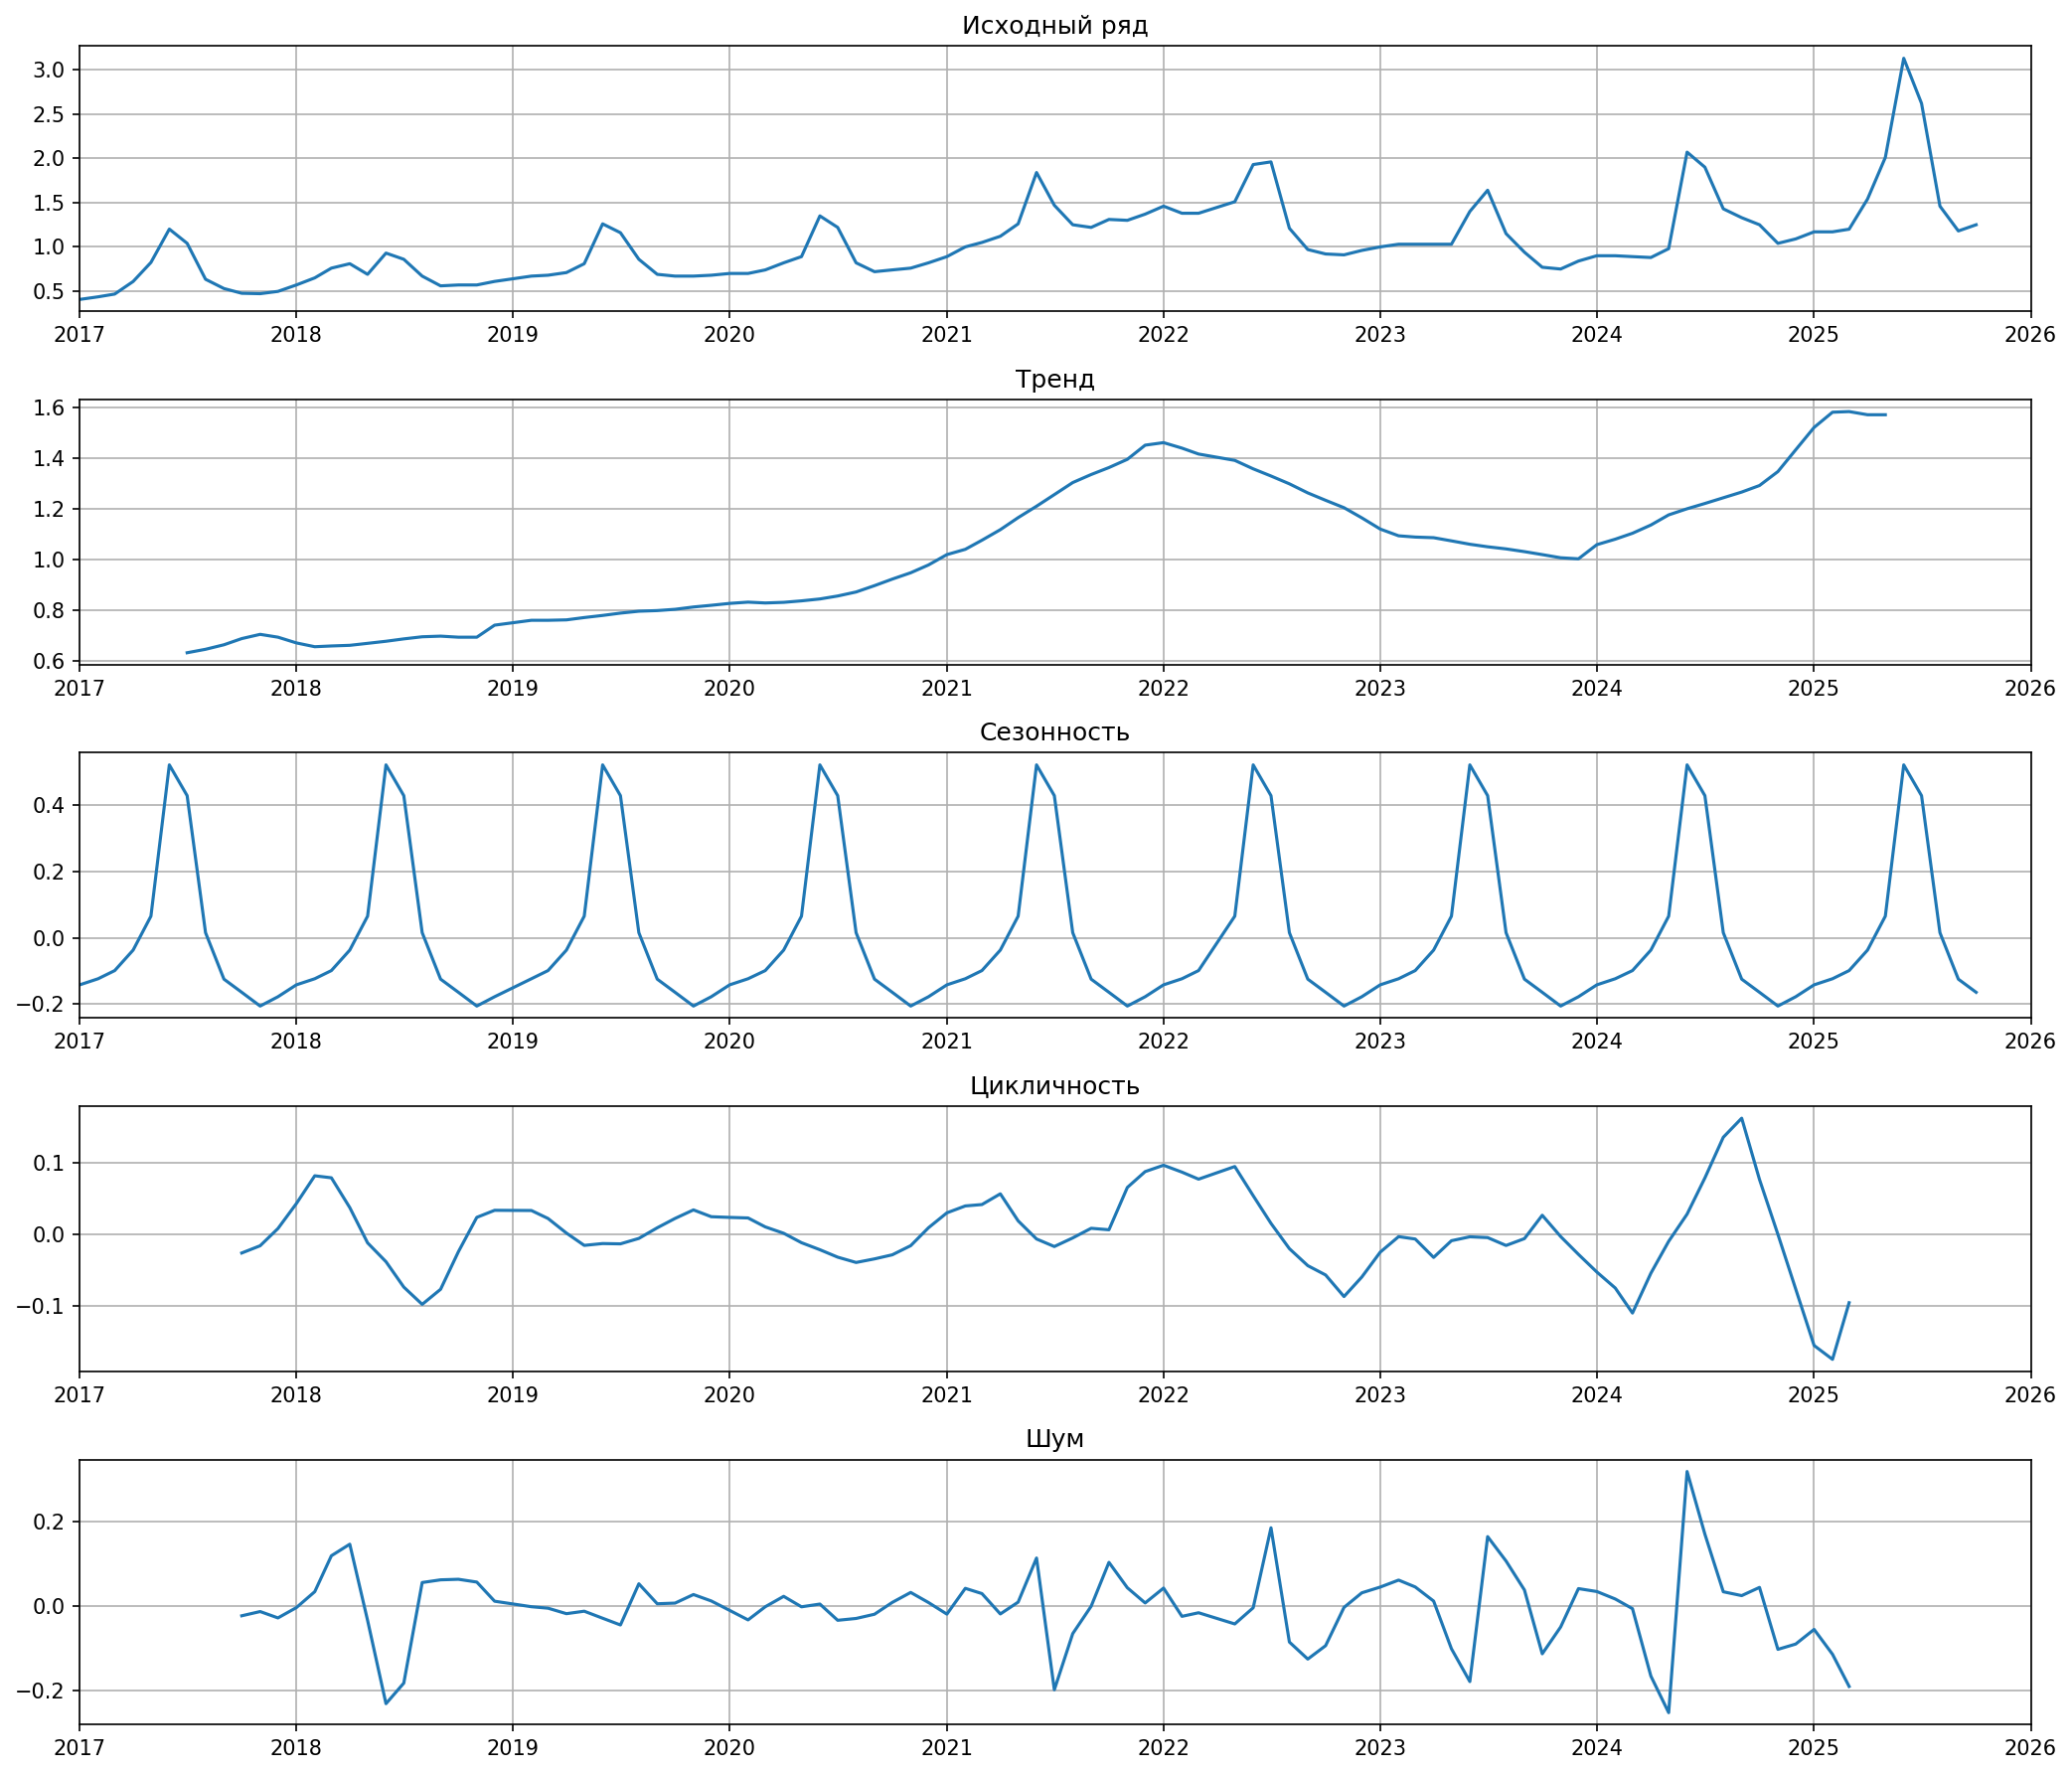

In [141]:
belarus_decomposed = decompose_time_series(df[df['region'] == 'Беларусь'])
plot_decomposition(belarus_decomposed)

На графике цикличности нет никаких устойчивых участков длительностью более 9 месяцев, из чего с высокой вероятностью следует, что циклическая компонента для данного набора данных отсутствует.

# Интеграция внешних факторов, влияющих на ценообразование

Очевидно, что наиболее влияющие на ценообразование факторы - объемы спроса и предложения. Но в свободном доступе найти достаточно подробную информацию об объемах сбора, площади посевов и т.д. во все рассматриваемые года у меня не получилось. Со среднемесячной температурой и количеством осадков примерно такая же ситуация. 

Я нашел ресурс, позволяющий в удобном виде (csv-файл) получить информацию о курсе валют (бел. рубль к доллару и рос. рублю): https://www.investing.com/currencies/byn-usd-historical-data. Полученные файлы: BYN_USD.csv и BYN_RUB.csv. Курс к рос. рублю может быть актуален из-за активного экспорта картофеля в Россию.

Также я добавил колонку, отмечающую месяцы, связанные с посадкой (апрель–май) и уборкой (август–сентябрь) картофеля.

### Анализ влияния курса валют

In [58]:
byn_usd = pd.read_csv('BYN_USD.csv')
byn_rub = pd.read_csv('BYN_RUB.csv')

In [59]:
byn_usd['Date'] = pd.to_datetime(byn_usd['Date'])
byn_rub['Date'] = pd.to_datetime(byn_rub['Date'])
byn_usd = byn_usd[['Date', 'Price']]
byn_rub = byn_rub[['Date', 'Price']]
byn_usd.columns=['date', 'byn_usd']
byn_rub.columns=['date', 'byn_rub']

In [48]:
byn_usd

,date,byn_usd
0,2025-10-01,0.2933
1,2025-09-01,0.2952
2,2025-08-01,0.2967
3,2025-07-01,0.3056
4,2025-06-01,0.3056
...,...,...
101,2017-05-01,0.5360
102,2017-04-01,0.5336
103,2017-03-01,0.5325
104,2017-02-01,0.5288


In [49]:
byn_rub

,date,byn_rub
0,2025-10-01,23.7013
1,2025-09-01,24.4680
2,2025-08-01,23.7051
3,2025-07-01,24.7816
4,2025-06-01,23.8954
...,...,...
101,2017-05-01,30.3415
102,2017-04-01,30.3718
103,2017-03-01,29.9444
104,2017-02-01,30.8295


In [60]:
df_ext_factors = df.merge(byn_usd, on='date', how='left')
df_ext_factors = df_ext_factors.merge(byn_rub, on='date', how='left')
df_ext_factors

,region,date,price,year,month,byn_usd,byn_rub
0,Беларусь,2017-01-01,0.406717,2017,1,0.5165,31.0483
1,Брестская,2017-01-01,0.365975,2017,1,0.5165,31.0483
2,Витебская,2017-01-01,0.398560,2017,1,0.5165,31.0483
3,Гомельская,2017-01-01,0.398695,2017,1,0.5165,31.0483
4,Гродненская,2017-01-01,0.327980,2017,1,0.5165,31.0483
...,...,...,...,...,...,...,...
827,Гомельская,2025-10-01,1.100000,2025,10,0.2933,23.7013
828,Гродненская,2025-10-01,1.130000,2025,10,0.2933,23.7013
829,г. Минск,2025-10-01,1.470000,2025,10,0.2933,23.7013
830,Минская,2025-10-01,1.160000,2025,10,0.2933,23.7013


In [82]:
df_ext_factors[df_ext_factors['region'] == 'Беларусь'][['price', 'byn_usd', 'byn_rub']].corr()['price'].sort_values(ascending=False )

price      1.000000
byn_rub   -0.423623
byn_usd   -0.574205
Name: price, dtype: float64

In [67]:
df_ext_factors = df_ext_factors.sort_values(['region', 'date'])
df_ext_factors

,region,date,price,year,month,byn_usd,byn_rub,season_phase
0,Беларусь,2017-01-01,0.406717,2017,1,0.5165,31.0483,normal
8,Беларусь,2017-02-01,0.436053,2017,2,0.5288,30.8295,normal
16,Беларусь,2017-03-01,0.467482,2017,3,0.5325,29.9444,normal
24,Беларусь,2017-04-01,0.609331,2017,4,0.5336,30.3718,planting
32,Беларусь,2017-05-01,0.824308,2017,5,0.5360,30.3415,lanting
...,...,...,...,...,...,...,...,...
797,г. Минск,2025-06-01,3.830000,2025,6,0.3056,23.8954,normal
805,г. Минск,2025-07-01,2.870000,2025,7,0.3056,24.7816,normal
813,г. Минск,2025-08-01,1.590000,2025,8,0.2967,23.7051,harvest
821,г. Минск,2025-09-01,1.290000,2025,9,0.2952,24.4680,harvest


In [77]:
df_ext_factors['usd_lag1'] = df_ext_factors.groupby('region')['byn_usd'].shift(1)
df_ext_factors['usd_lag2'] = df_ext_factors.groupby('region')['byn_usd'].shift(2)
df_ext_factors['usd_lag3'] = df_ext_factors.groupby('region')['byn_usd'].shift(3)

df_ext_factors['rub_lag1'] = df_ext_factors.groupby('region')['byn_rub'].shift(1)
df_ext_factors['rub_lag2'] = df_ext_factors.groupby('region')['byn_rub'].shift(2)
df_ext_factors['rub_lag3'] = df_ext_factors.groupby('region')['byn_rub'].shift(3)

In [81]:
df_ext_factors[df_ext_factors['region'] == 'Беларусь'][['price', 'usd_lag1', 'usd_lag2', 'usd_lag3', 'rub_lag1', 'rub_lag2', 'rub_lag3']].corr()['price']

price       1.000000
usd_lag1   -0.593751
usd_lag2   -0.601907
usd_lag3   -0.603701
rub_lag1   -0.458269
rub_lag2   -0.389807
rub_lag3   -0.279147
Name: price, dtype: float64

Имеется заметная отрицательная корреляция цены (ср. по Беларуси) и курса бел. рубля к доллару. При добавление лагов на 1-3 месяца корреляция еще немного увеличивается. 

С лагом на месяц корреляция цены и курса бел. рубля к рос. рублю тоже довольно значительная.

### Анализ влияния периодов посадки и сбора урожая

In [55]:
df_ext_factors['is_harvest'] = df_ext_factors['month'].isin([8, 9, 10]) 
df_ext_factors['is_planting'] = df_ext_factors['month'].isin([4, 5]) 
df_ext_factors['winter_season'] = df_ext_factors['month'].isin([11, 12, 1, 2])

In [93]:
df_ext_factors['season_phase'] = df_ext_factors['month'].map({
    4: 'посадка',
    5: 'посадка',
    8: 'сбор',
    9: 'сбор'
}).fillna('остальное')

In [94]:
df_ext_factors[df_ext_factors['region'] == 'Беларусь'].groupby('season_phase')['price'].mean()

season_phase
остальное    1.065315
посадка      1.030802
сбор         0.979109
Name: price, dtype: float64

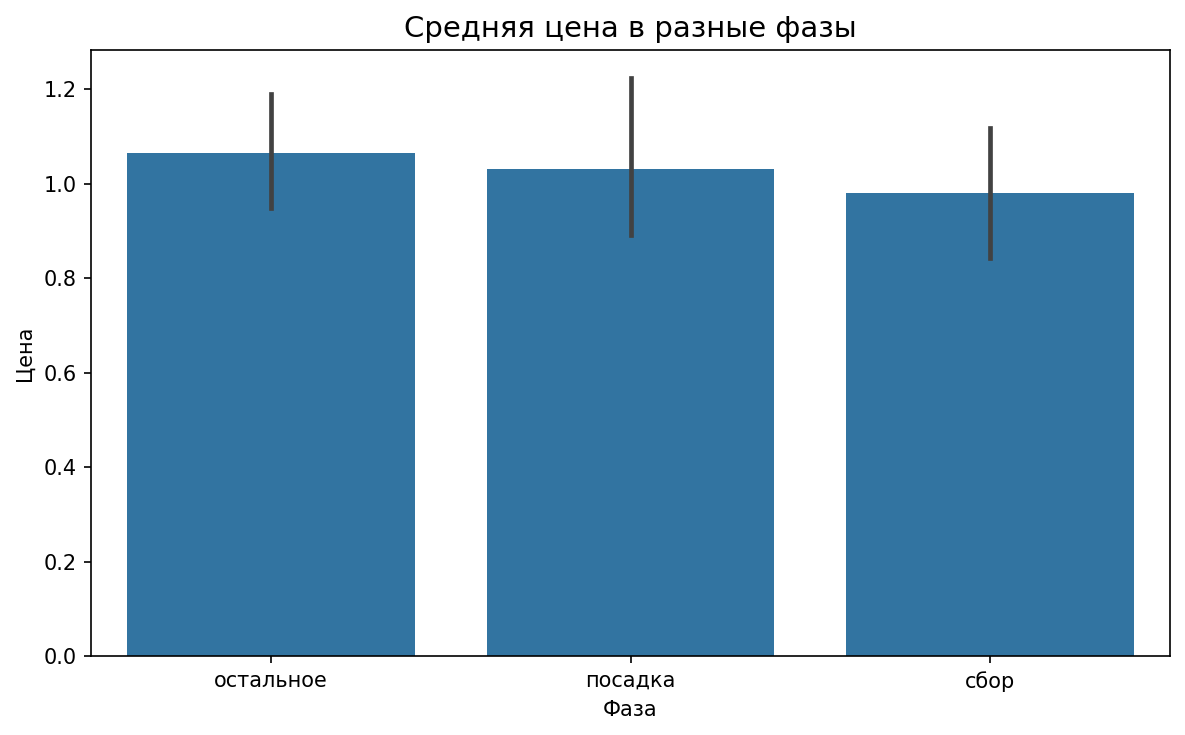

In [95]:
plt.figure(figsize=(8, 5), dpi=150)
sns.barplot(data=df_ext_factors[df_ext_factors['region'] == 'Беларусь'], x='season_phase', y='price');

plt.title('Средняя цена в разные фазы', fontsize=14)
plt.xlabel('Фаза')
plt.ylabel('Цена')
plt.tight_layout();

По графику видно, что период посадки и сбора по крайней мере напрямую не сильно влияют на цену, хотя во время сбора цена все таки немного ниже.

# Построение прогнозных моделей с оценкой точности

### Прогноз с комбинацией сезонности и тренда

In [99]:
bel = df[df['region'] == 'Беларусь'].copy()
bel['t'] = np.arange(len(bel))

In [100]:
bel

,region,date,price,year,month,t
0,Беларусь,2017-01-01,0.406717,2017,1,0
8,Беларусь,2017-02-01,0.436053,2017,2,1
16,Беларусь,2017-03-01,0.467482,2017,3,2
24,Беларусь,2017-04-01,0.609331,2017,4,3
32,Беларусь,2017-05-01,0.824308,2017,5,4
...,...,...,...,...,...,...
792,Беларусь,2025-06-01,3.130000,2025,6,99
800,Беларусь,2025-07-01,2.620000,2025,7,100
808,Беларусь,2025-08-01,1.460000,2025,8,101
816,Беларусь,2025-09-01,1.180000,2025,9,102


In [104]:
a, b = np.polyfit(bel["t"], bel["price"], deg=1)
bel["trend"] = a * bel["t"] + b

bel["residual"] = bel["price"] - bel["trend"]
season = bel.groupby("month")["residual"].mean()

bel["seasonality"] = bel["month"].map(season)
bel["forecast"] = bel["trend"] + bel["seasonality"]


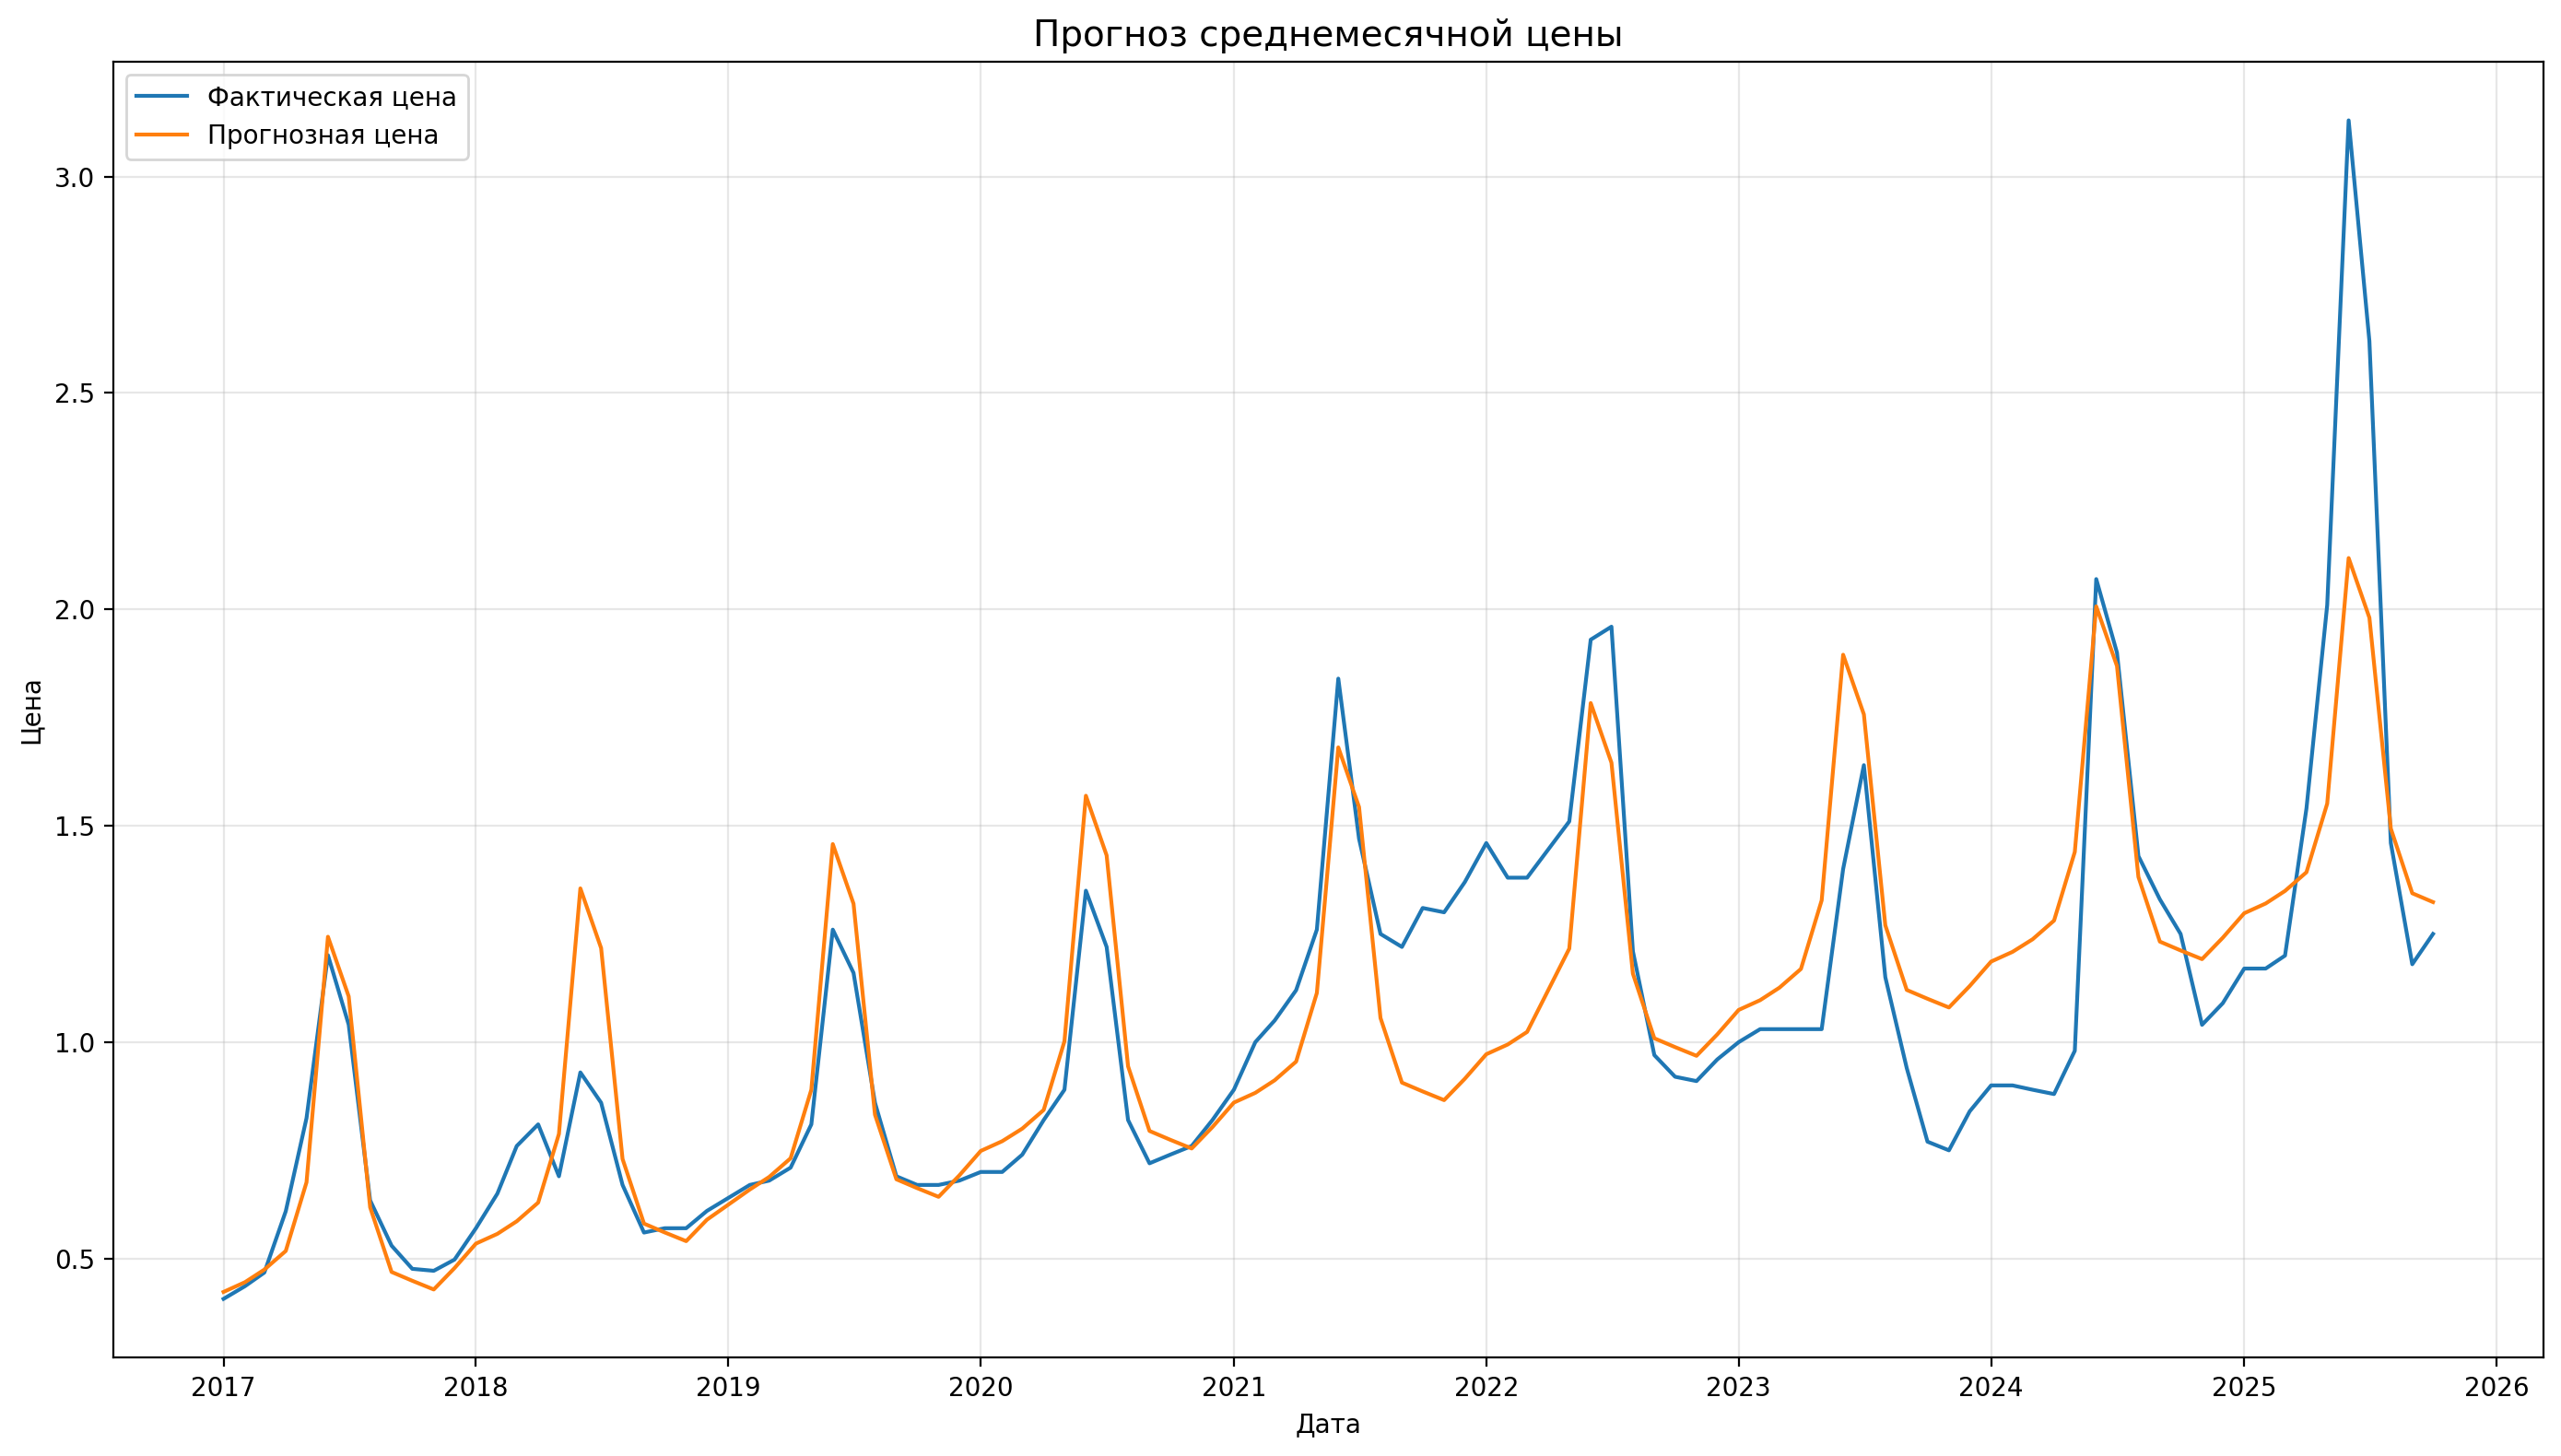

In [109]:
plt.figure(figsize=(14, 8), dpi=200)
plt.plot(bel["date"], bel["price"], label='Фактическая цена')
plt.plot(bel["date"], bel["forecast"], label='Прогнозная цена')
plt.title('Прогноз среднемесячной цены', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout();

In [114]:
mae = (bel["price"] - bel["forecast"]).abs().mean()
mape = ((bel["price"] - bel["forecast"]).abs() / bel["price"]).mean() * 100
print("MAE:", round(mae, 3))
print("MAPE:", str(round(mape, 3))+'%')


MAE: 0.158
MAPE: 13.989%


#### Прогноз на следующие 12 месяцев

In [115]:
future_months = 12
last_t = bel["t"].iloc[-1]

future_t = np.arange(last_t + 1, last_t + 1 + future_months)
future_trend = a * future_t + b
future_month = [(bel["month"].iloc[-1] + i) % 12 or 12 for i in range(1, future_months+1)]
future_season = [season[m] for m in future_month]

future_forecast = future_trend + future_season


In [125]:
def generate_dates(start_date, count):
    dates = []
    for i in range(count + 1):
        year = start_date.year + (start_date.month + i - 1) // 12
        month = (start_date.month + i - 1) % 12 + 1
        day = min(start_date.day, (date(year, month, 1) - timedelta(days=1)).day)
        dates.append(date(year, month, day))
    return dates[1:]

In [127]:
pd.DataFrame({'date': generate_dates(bel['date'].iloc[-1], 12),
              'price': future_forecast})

,date,price
0,2025-11-01,1.303518
1,2025-12-01,1.352997
2,2026-01-01,1.409584
3,2026-02-01,1.432077
4,2026-03-01,1.461124
5,2026-04-01,1.504303
6,2026-05-01,1.662917
7,2026-06-01,2.230312
8,2026-07-01,2.092483
9,2026-08-01,1.605133


### Прогнозная модель на основе случайных лесов

В задании сказано использовать только pandas, но из личного интереса мне захотелось попробовать случайные леса из scikit-learn для этого набора данных, гиперпараметры особо не подбирал

In [139]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [140]:
data = df[df['region'] == 'Беларусь'].drop(columns=['region', 'date']).copy()

In [142]:
data['is_harvest'] = data['month'].isin([8, 9, 10]) 
data['is_planting'] = data['month'].isin([4, 5]) 
data['winter_season'] = data['month'].isin([11, 12, 1, 2])
data["t"] = np.arange(len(data))

for lag in [1, 2, 3, 6, 12]:
    data[f"lag_{lag}"] = data["price"].shift(lag)

data = data.dropna()

In [149]:
X = data.drop(columns=['price'])
y = data['price']
train_size = int(len(data) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [152]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, 96 to 672
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           73 non-null     int32  
 1   month          73 non-null     int32  
 2   is_harvest     73 non-null     bool   
 3   is_planting    73 non-null     bool   
 4   winter_season  73 non-null     bool   
 5   t              73 non-null     int32  
 6   lag_1          73 non-null     float64
 7   lag_2          73 non-null     float64
 8   lag_3          73 non-null     float64
 9   lag_6          73 non-null     float64
 10  lag_12         73 non-null     float64
dtypes: bool(3), float64(5), int32(3)
memory usage: 4.5 KB


In [157]:
model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=3
)

model.fit(X_train, y_train)


RandomForestRegressor(min_samples_split=3, n_estimators=500, random_state=42)

In [154]:
y_pred = model.predict(X_test)

Метрики на тестовых данных (плохие показатели, т.к. 2025 год довольно сильно отличается по динамике от всех остальных и занимает около половины тестовой выборки)

In [165]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_error(y_test, y_pred) / bel["price"].mean() * 100

print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("MAPE:", str(round(mape, 3)) + '%')

MAE: 0.338
RMSE: 0.5
MAPE: 32.398%


Метрики на всех данных

In [162]:
mae = mean_absolute_error(y, model.predict(X))
rmse = np.sqrt(mean_squared_error(y, model.predict(X)))
mape = mean_absolute_error(y, model.predict(X)) / bel["price"].mean() * 100

print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("MAPE:", str(round(mape, 3)) + '%')

MAE: 0.104
RMSE: 0.238
MAPE: 9.959%


На всех данных случайные леса показали себя немного лучше, чем простая прогнозная модель с комбинацией сезонности и тренда, но она чуть сложнее в применении к прогнозам на будущее, так как она обучалась на данных, содержащих доволльно много произодных ячеек.